In [1]:
from TCP.resnet import *
from PIL import Image
from torchvision import transforms as T
import numpy as np
import torchvision
from TCP.data import CARLA_Data
from TCP.config import GlobalConfig
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
perception = resnet34(pretrained=True)

In [14]:
perception.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
root_dir_all = "/storage/scratch/e17-4yp-autonomous-driving/g04/TCPDataset/tcp_carla_data"


In [51]:
train_towns = ['town01', 'town03', 'town04',  'town06', ]
val_towns = ['town02', 'town05', 'town07', 'town10']
train_data, val_data = [], []
for town in train_towns:		
    train_data.append(os.path.join(root_dir_all, town))
    train_data.append(os.path.join(root_dir_all, town+'_addition'))
for town in val_towns:
    val_data.append(os.path.join(root_dir_all, town+'_val'))

In [52]:
train_set = CARLA_Data(root=root_dir_all, data_folders=train_data, img_aug = True)

In [53]:
dataloader_train = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=8)

In [54]:
dataloader_train

In [55]:
batch1 = next(iter(dataloader_train))

In [56]:
fImg = batch1['front_img']

In [66]:
feature_emb, cnn_feature = perception(fImg)

In [67]:
print("Feature embeddings shape:", feature_emb.shape)
print("CNN features shape:", cnn_feature.shape)

Feature embeddings shape: torch.Size([32, 1000])
CNN features shape: torch.Size([32, 512, 8, 29])


In [83]:
with torch.no_grad():
    input_tensor = fImg
    feature_emb = perception(input_tensor)
    cnn_feature = perception.conv1(input_tensor)  # Extract features from a specific layer (e.g., conv1)

### Activation Maps
 Activation maps visualize the output of individual feature maps in a layer. By selecting a specific feature map, you can visualize the regions of the input image that activate that particular feature. This provides insights into what the network focuses on and what features it detects at different layers.

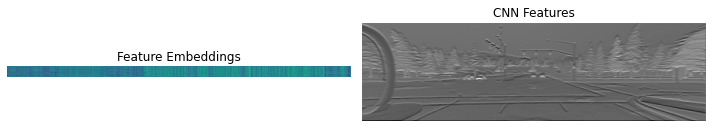

In [93]:
# Visualize the feature embeddings
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(feature_emb[0].squeeze().cpu().numpy(), cmap='viridis')
plt.title('Feature Embeddings')
plt.axis('off')

# Visualize the CNN features
plt.subplot(1, 2, 2)
plt.imshow(cnn_feature[0, 0].cpu().numpy(), cmap='gray')
plt.title('CNN Features')
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

### Filter Visualization
Filter visualization techniques aim to visualize the learned filters in the convolutional layers. These methods generate synthetic input images that maximize the activation of a particular filter. By visualizing the generated images, you can get an idea of what visual patterns or concepts the filters are sensitive to.

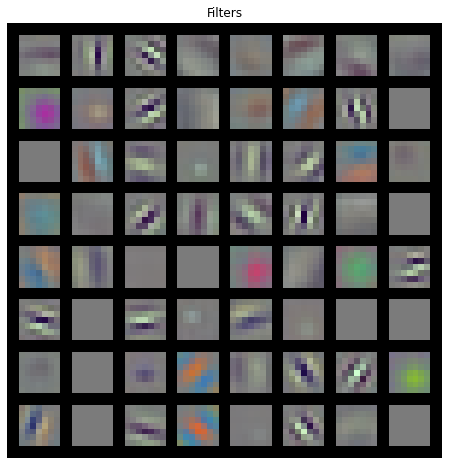

In [95]:
plt.figure(figsize=(8, 8))
filter_weights = perception.conv1.weight.cpu().detach().numpy()
filter_grid = torchvision.utils.make_grid(torch.from_numpy(filter_weights), nrow=8, normalize=True)
plt.imshow(filter_grid.permute(1, 2, 0))
plt.title('Filters')
plt.axis('off')
plt.show()

### t-SNE Visualization
t-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique that can be applied to feature embeddings to visualize high-dimensional representations in a lower-dimensional space. It aims to preserve the local structure and relationships between samples. By applying t-SNE to feature embeddings, you can visualize clusters or patterns in the data.

/storage/scratch/e17-4yp-autonomous-driving/anaconda3/envs/TCP/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/storage/scratch/e17-4yp-autonomous-driving/anaconda3/envs/TCP/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


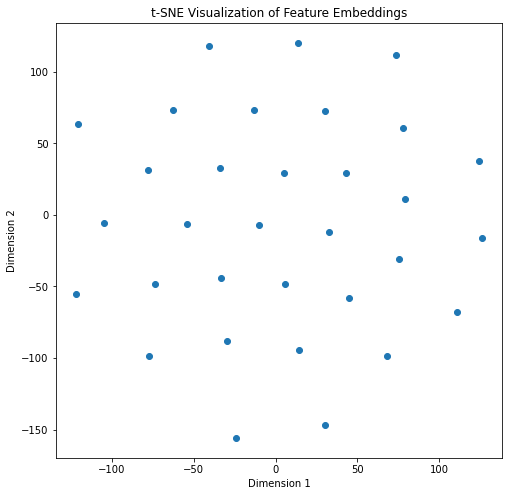

In [86]:
# Perform t-SNE on the feature embeddings
tsne = TSNE(n_components=2, random_state=0)
feature_emb_tsne = tsne.fit_transform(feature_emb[0].squeeze().cpu().numpy())

# Visualize the t-SNE embeddings
plt.figure(figsize=(8, 8))
plt.scatter(feature_emb_tsne[:, 0], feature_emb_tsne[:, 1])
plt.title('t-SNE Visualization of Feature Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

### Class Activation Mapping (CAM)

CAM is a technique used to visualize the discriminative regions of an image that contribute to the prediction of a specific class. It highlights the regions that the network focuses on to make its predictions. CAM can be used to visualize which parts of an image are most important for a specific class and gain insights into the reasoning of the network.

In [89]:
# Get the class activation map
class_activation_map = torch.matmul(perception.fc.weight.T, feature_emb[0].squeeze().T).squeeze().cpu().detach().numpy()
class_activation_map = np.maximum(class_activation_map, 0)  # Apply ReLU

# Normalize the class activation map
class_activation_map = (class_activation_map - np.min(class_activation_map)) / (
        np.max(class_activation_map) - np.min(class_activation_map))

# Upsample the class activation map to the input image size
upsampled_cam = transforms.Resize((fImg.shape[2], fImg.shape[3]))(Image.fromarray(class_activation_map))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


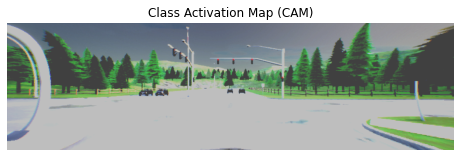

In [92]:
plt.figure(figsize=(8, 8))
plt.imshow(upsampled_cam, cmap='jet', alpha=0.5)
plt.imshow(fImg[0].permute(1, 2, 0).cpu().numpy(), alpha=0.5)
plt.title('Class Activation Map (CAM)')
plt.axis('off')
plt.show()